In [142]:
import os 
import sys
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import DataLoader

from torchvision import datasets, transforms, utils

from tqdm import tqdm

from vqvae import VQVAE
sys.path.append('/home/shirakawa/kspy')
sys.path.append('/home/shirakawa/kspy/bdpy3')
from tile_images import tile_images
from fig import makefigure

In [2]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [153]:
save_dir = 'KS_res'
os.makedirs(save_dir, exist_ok=True)

In [3]:
model = VQVAE()

In [4]:
model.load_state_dict(torch.load('./checkpoint/vqvae_006.pt',map_location=torch.device('cpu')))
#model.load_state_dict(torch.load('vqvae_560.pt',map_location=torch.device('cpu')))
model.eval()

VQVAE(
  (enc_b): Encoder(
    (blocks): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ResBlock(
        (conv): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU(inplace=True)
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (6): ResBlock(
        (conv): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU(inplace=True)
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (7): ReLU(inplace=True)
    )
  )
  (enc_t): Encoder(
    (blocks): Sequential(
      (0): Conv2d(128, 64,

In [5]:
imagenettest_dir = '/home/shirakawa/movie/data/contents_shared/ImageNetTest/source'

#imagenettest_dir = '/home/shirakawa/movie/data/contents_shared/stimulus_artificial_shape_v1/derivatives/frames/f0t90_224x224/ll2rr_s_black_60_high'

In [6]:
def pp(inp):
    return inp.detach().numpy().transpose(1,2,0) * 0.5 + 0.5

In [7]:
img_list = np.sort(os.listdir(imagenettest_dir))[::10]

In [48]:
true_img_dict = {}

#obtain latent values
ls_dict ={}
lv_dict = {}

for img_file in img_list:
    #load image
    img = Image.open(os.path.join(imagenettest_dir, img_file))
    true_img_dict[img_file] = np.asarray(img.resize([224, 224]))
    
    qa = model.encode(transform(img)[np.newaxis])
    
    
    # latent space
    ls_t = qa[0]
    ls_b = qa[1]
    
    #latent vector
    lv_t = qa[-2]
    lv_b = qa[-1]
    
    ls_dict[img_file] = [ls_t, ls_b]
    lv_dict[img_file] = [lv_t, lv_b]
    
    

In [49]:
#decode from original

dec_ls_dict = {}
dec_lv_dict = {}
dec_lv_from_ls_dict = {}
for img_file in img_list:
    #decode from ls
    
    feat_t, feat_b = ls_dict[img_file]
    
    recon_img = model.decode(feat_t, feat_b)[0]
    
    pp_img = pp(recon_img)
    
    dec_ls_dict[img_file] = np.uint8(pp_img * 255)
    
    #decode from lv
    feat_t, feat_b = lv_dict[img_file]
    
    recon_img = model.decode_code(feat_t, feat_b)[0]
    
    pp_img = pp(recon_img)
    
    dec_lv_dict[img_file] = np.uint8(pp_img * 255)
    
    
    #decode from lv cretead by ls
    feat_t, feat_b = ls_dict[img_file]
    q_t = model.quantize_t(feat_t.permute(0, 2,3, 1 ))[-1]
    q_b = model.quantize_b(feat_b.permute(0, 2,3, 1 ))[-1]
    recon_img = model.decode_code(q_t, q_b)[0]
    pp_img = pp(recon_img)
    
    dec_lv_from_ls_dict[img_file] = np.uint8(pp_img * 255)
    
    
    
    

In [80]:
label_list = ['true'] * len(img_list)  + ['latent']* len(img_list) + ['quantize']* len(img_list)+  ['quantized \n latent']* len(img_list)
              
              

    

In [81]:
label_list

['true',
 'true',
 'true',
 'true',
 'true',
 'latent',
 'latent',
 'latent',
 'latent',
 'latent',
 'quantize',
 'quantize',
 'quantize',
 'quantize',
 'quantize',
 'quantized \n latent',
 'quantized \n latent',
 'quantized \n latent',
 'quantized \n latent',
 'quantized \n latent']

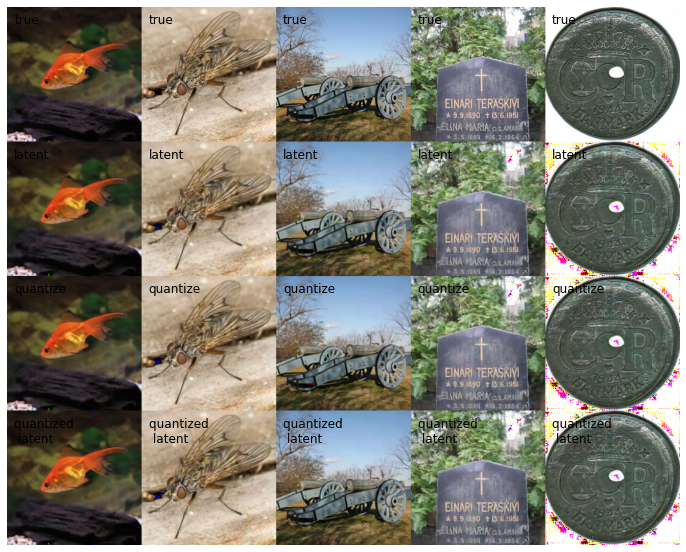

In [156]:
fig = makefigure()
fig = tile_images(list(true_img_dict.values()) + list(dec_ls_dict.values()) +list(dec_lv_dict.values()) +list(dec_lv_from_ls_dict.values()) , 
            ncols=5, labels=label_list, fig=fig)


fig.savefig(os.path.join(save_dir, 'recon_images.pdf'))

torch.Size([1, 28, 28])

In [149]:
## add gaussian noise 
std_list = [0, 0.001, 0.1, 0.5, 1.0, 3.0 ,5.0, 10]
img_file = img_list[0]
show_list = [true_img_dict[img_file], true_img_dict[img_file]]
show_label_list = ['true', 'true']

ls_feat =ls_dict[img_file]
ls_t, ls_b = ls_feat
for std in std_list:
    
    rand_t =ls_t + torch.randn(ls_t.shape) * std 
    rand_b = ls_b + torch.randn(ls_b.shape)* std
    
    #latent space 
    dec_img = model.decode(rand_t, rand_b )[0]
    pp_img = pp(dec_img)
    
    show_list.append(np.uint8(pp_img * 255))
    show_label_list.append(f'std:{std} l ')
    #quantize
    q_t = model.quantize_t(rand_t.permute(0, 2,3, 1 ))[-1]
    q_b = model.quantize_b(rand_b.permute(0, 2,3, 1 ))[-1]
    
    dec_img = model.decode_code(q_t, q_b )[0]
    pp_img = pp(dec_img)
    
    show_list.append(np.uint8(pp_img * 255))
    show_label_list.append(f'q_from_l')
    
    
    
    


In [150]:
show_list[0].shape

(224, 224, 3)

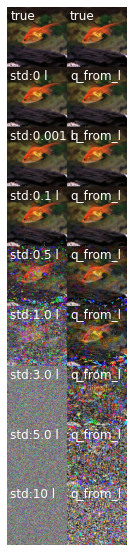

In [157]:
fig = makefigure()
fig = tile_images(show_list,
            ncols=2, labels=show_label_list, fig=fig, label_color='white')

fig.savefig(os.path.join(save_dir, 'recon_image_with_gnoise.pdf'))

2

In [88]:
show_list.shape

(224, 224, 3)

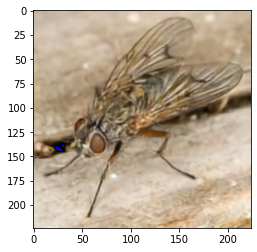

In [14]:
plt.imshow(np.uint8(pp_img * 255))

In [9]:
#show images



In [108]:
post_process = qq[0][0].detach().numpy().transpose(1,2,0) * 0.5 + 0.5

In [109]:
def pp(inp):
    return inp.detach().numpy().transpose(1,2,0) * 0.5 + 0.5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


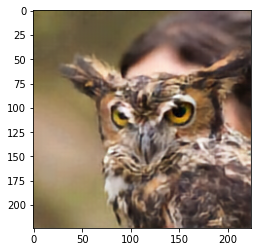

In [110]:
plt.imshow(post_process)

In [111]:
qa = model.encode(transform(img)[np.newaxis])

In [129]:
qa[0]

tensor([[[[ 0.1029,  0.1029,  0.1029,  ..., -0.0089, -0.0089,  0.0545],
          [ 0.1029,  0.0545,  0.0874,  ...,  0.0164,  0.0164, -0.0089],
          [ 0.0874,  0.0874,  0.0874,  ...,  0.0545,  0.0545,  0.0164],
          ...,
          [ 0.0545,  0.0545,  0.0545,  ...,  0.0545,  0.0545,  0.0545],
          [ 0.0545,  0.0545,  0.0545,  ...,  0.0240, -0.0089, -0.0089],
          [ 0.0545,  0.0545,  0.0545,  ...,  0.0164,  0.0545,  0.0545]],

         [[-0.0434, -0.0434, -0.0434,  ...,  0.1003,  0.1003,  0.0125],
          [-0.0434,  0.0125, -0.0647,  ...,  0.0464,  0.0464,  0.1003],
          [-0.0647, -0.0647, -0.0647,  ...,  0.0125,  0.0125,  0.0464],
          ...,
          [ 0.0125,  0.0125,  0.0125,  ...,  0.0125,  0.0125,  0.0125],
          [ 0.0125,  0.0125,  0.0125,  ...,  0.0025,  0.1003,  0.1003],
          [ 0.0125,  0.0125,  0.0125,  ...,  0.0464,  0.0125,  0.0125]],

         [[ 0.0598,  0.0598,  0.0598,  ...,  0.0189,  0.0189,  0.0124],
          [ 0.0598,  0.0124, -

In [113]:
qa[0].shape

torch.Size([1, 64, 28, 28])

In [114]:
qa[1].shape

torch.Size([1, 64, 56, 56])

(array([2.5000e+01, 8.1000e+01, 6.5700e+02, 4.4890e+03, 2.1658e+04,
        1.9362e+04, 3.3430e+03, 4.5700e+02, 1.0300e+02, 1.0000e+00]),
 array([-0.41852307, -0.33416796, -0.24981281, -0.1654577 , -0.08110256,
         0.00325257,  0.0876077 ,  0.17196283,  0.25631794,  0.3406731 ,
         0.4250282 ], dtype=float32),
 <BarContainer object of 10 artists>)

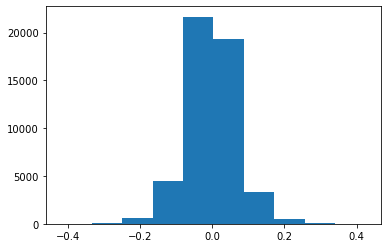

In [115]:
plt.hist(qa[0].detach().numpy().flatten())

In [116]:
qa[-1].shape

torch.Size([1, 56, 56])

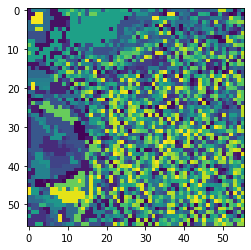

In [125]:
plt.imshow(qa[-1][0].detach().numpy())

In [118]:
torch.randn(qa[0].shape)

tensor([[[[-1.2100,  0.1719,  1.4198,  ...,  0.5149,  0.3712, -0.3067],
          [-1.1607, -0.9336, -0.1257,  ..., -0.1063, -0.0089,  1.0159],
          [-0.4065,  0.2859, -0.8177,  ..., -0.4596, -0.6433, -0.2538],
          ...,
          [-0.6208,  1.2035,  1.4083,  ..., -1.2788, -0.8337,  0.3153],
          [ 1.1363,  0.3413, -0.4462,  ..., -0.4632,  1.5751, -0.2486],
          [ 0.4225, -0.1656,  0.1784,  ...,  0.9643, -0.1217, -1.8956]],

         [[-0.3379, -0.7326,  0.7994,  ...,  1.5470,  0.8279,  0.6644],
          [ 2.0713, -1.4728, -0.4133,  ...,  0.9148,  0.4142, -2.1657],
          [ 0.0776, -0.1377,  0.6529,  ..., -1.3730,  0.1798,  0.1432],
          ...,
          [-0.6476, -0.7289,  0.3649,  ..., -1.0560, -2.4683,  0.8197],
          [-1.2176,  0.4670, -0.5678,  ...,  0.1322, -1.2615,  2.5363],
          [-0.6195,  0.1919, -0.5377,  ..., -0.0597, -0.2009,  0.1371]],

         [[-1.4976, -0.4041,  0.1169,  ...,  0.1799, -0.5699,  0.9182],
          [-1.7654,  0.2580, -

In [119]:
dec = model.decode_code(qa[-2], qa[-1])[0]

img_dec = pp(dec)

In [136]:
qa[-2]

tensor([[[221, 221, 221, 221,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          221,   4, 221, 221, 221,   7, 264, 264, 264, 264, 264, 264, 264,   0],
         [221,   0,   4,   0,   0,   0,   0,   0,   0,   0,   0,   4,   0,   4,
            4, 221,   0, 111, 264, 264, 264, 264, 264,   7,   7,   7,   7, 264],
         [  4,   4,   4,   0,   0,   0,   0,   0,   0,   4,   0,   0,   0,   4,
            0,   7, 264, 329, 329, 329,   7,   0, 264, 264,   7,   0,   0,   7],
         [221,   4,   0,   0,   0,   0,   0,   0,   0,   0,   0,   4,   4, 221,
          264, 329,   0,   0,   7, 264, 264, 264,   7, 264, 264,   0,   7,   0],
         [  0,   0,   0,   0,   0,   0,   0,   4,   0,   0,   0, 221,   0,   0,
            7,   7, 264, 329,   7,   7, 264,   0,   0,   7, 329,   7,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0, 329,   4,   0,   4,   0,   7,   6,
          329, 329, 329,   8, 329,   0,   0, 264, 264, 329, 111, 329, 329,   0],
         [  0,   0,   0,   0, 221,

In [137]:
model.quantize_t(qa[0].permute(0, 2,3, 1 ))[-1] == qa[-2]

tensor([[[True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True],
     

In [120]:
dec = model.decode(qa[0] , qa[1])[0]

img_dec = pp(dec)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


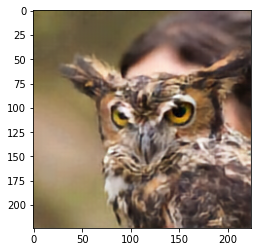

In [121]:
plt.imshow(img_dec)

In [122]:
dec = model.decode_code(qa[-2], qa[-1])[0]

img_dec = pp(dec)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


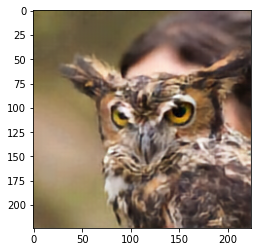

In [123]:
plt.imshow(img_dec)

In [124]:
qa[-2]

tensor([[[221, 221, 221, 221,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          221,   4, 221, 221, 221,   7, 264, 264, 264, 264, 264, 264, 264,   0],
         [221,   0,   4,   0,   0,   0,   0,   0,   0,   0,   0,   4,   0,   4,
            4, 221,   0, 111, 264, 264, 264, 264, 264,   7,   7,   7,   7, 264],
         [  4,   4,   4,   0,   0,   0,   0,   0,   0,   4,   0,   0,   0,   4,
            0,   7, 264, 329, 329, 329,   7,   0, 264, 264,   7,   0,   0,   7],
         [221,   4,   0,   0,   0,   0,   0,   0,   0,   0,   0,   4,   4, 221,
          264, 329,   0,   0,   7, 264, 264, 264,   7, 264, 264,   0,   7,   0],
         [  0,   0,   0,   0,   0,   0,   0,   4,   0,   0,   0, 221,   0,   0,
            7,   7, 264, 329,   7,   7, 264,   0,   0,   7, 329,   7,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0, 329,   4,   0,   4,   0,   7,   6,
          329, 329, 329,   8, 329,   0,   0, 264, 264, 329, 111, 329, 329,   0],
         [  0,   0,   0,   0, 221,

In [90]:
torch.randint(0,255 ,(1,56, 56))

tensor([[[172,  80, 155,  ..., 155,  96,  63],
         [193, 118,  68,  ..., 134, 120, 106],
         [ 98, 241, 177,  ..., 108,  83,  31],
         ...,
         [ 23, 187,  73,  ...,  52, 168, 161],
         [129, 168, 185,  ...,  79,  14, 212],
         [228, 127, 253,  ..., 140, 195,  12]]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


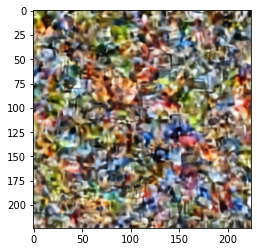

In [99]:
dec = model.decode_code(torch.randint(0,255 ,(1,28, 28)), torch.randint(0,255 ,(1,56, 56)))[0]

img_rand = pp(dec)

plt.imshow(img_rand)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


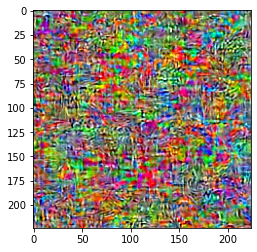

In [101]:
dec = model.decode(torch.randn(qa[0].shape), torch.randn(qa[1].shape))[0]

img_rand = pp(dec)

plt.imshow(img_rand)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
non quant


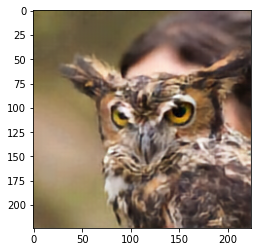

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


quant


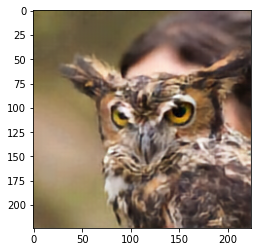

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.001
non quant


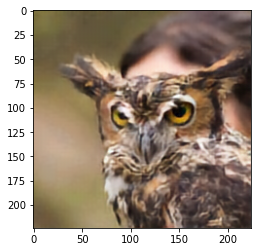

quant


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


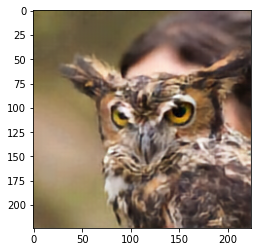

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.1
non quant


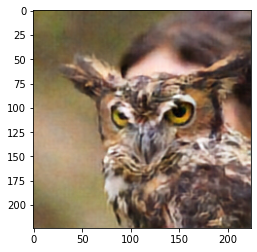

quant


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


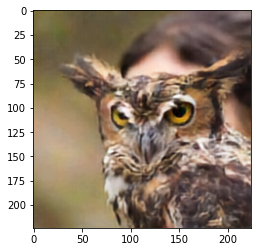

0.5
non quant


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


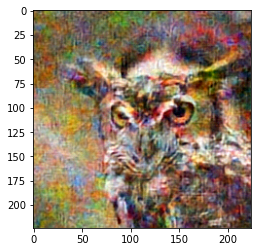

quant


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


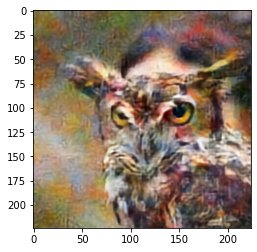

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1.0
non quant


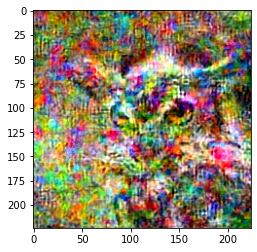

quant


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


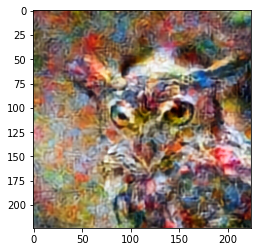

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3.0
non quant


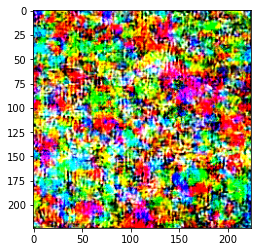

quant


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


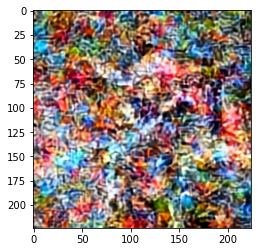

5.0
non quant


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


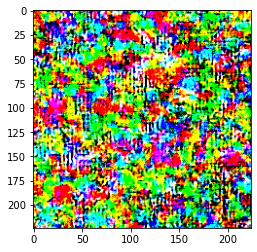

quant


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


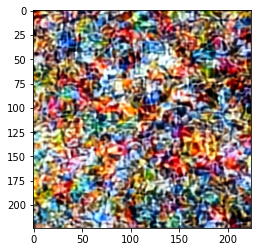

10
non quant


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


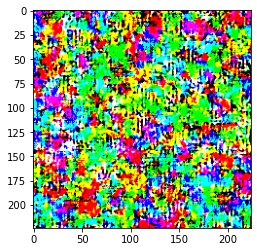

quant


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


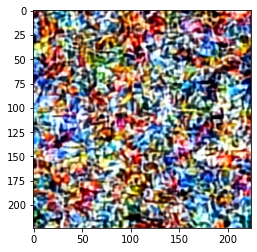

In [149]:
std_list = [0, 0.001, 0.1, 0.5, 1.0, 3.0 ,5.0, 10]


for std in std_list:
    print(std)
    print('non quant')
    
    rand_t = qa[0] + torch.randn(qa[0].shape) * std 
    rand_b = qa[1] + torch.randn(qa[1].shape)* std
    dec = model.decode(rand_t, rand_b )[0]

    img_dec = pp(dec)

    plt.imshow(img_dec)
    plt.show()
    
    
    
    #
    print("quant")
    q_t = model.quantize_t(rand_t.permute(0, 2,3, 1 ))[-1]
    q_b = model.quantize_b(rand_b.permute(0, 2,3, 1 ))[-1]
    
    dec = model.decode_code(q_t, q_b )[0]
    img_dec = pp(dec)

    plt.imshow(img_dec)
    plt.show()

In [147]:
q_b.shape

torch.Size([1, 56, 56])

In [278]:
qq = qa[1] + torch.randn(qa[1].shape) * 2.0

In [279]:
qq.detach().numpy().flatten()

array([ 0.5525037 , -3.344109  ,  1.2715658 , ..., -0.81361896,
        0.3473795 ,  1.9018669 ], dtype=float32)

In [280]:
qa[1].detach().numpy().flatten()

array([ 0.02085202,  0.02085202, -0.00163652, ..., -0.8189864 ,
       -0.9383432 , -0.9383432 ], dtype=float32)

In [281]:
np.corrcoef(qq.detach().numpy().flatten(), qa[1].detach().numpy().flatten())

array([[1.        , 0.21056962],
       [0.21056962, 1.        ]])

In [295]:
l1_list = []
l2_list = []
for img_file in img_list:
    img = Image.open(os.path.join(imagenettest_dir, img_file))
    qa = model.encode(transform(img)[np.newaxis])
    
    l1_list.append(qa[0].detach().numpy().squeeze())
    l2_list.append(qa[1].detach().numpy().squeeze())
    
l1_list = np.array(l1_list)
l2_list = np.array(l2_list)

In [309]:
l1_list.reshape(50, -1).mean(0)

array([-0.00868445, -0.00708789, -0.00584255, ...,  0.01157265,
       -0.0051611 ,  0.01305078], dtype=float32)

In [310]:
l1_list.reshape(50, -1).std(0)

array([0.11455472, 0.07984001, 0.1073643 , ..., 0.05653872, 0.05181348,
       0.06635645], dtype=float32)

In [311]:
l2_list.reshape(50, -1).mean(0)

array([-0.05143332, -0.03841956, -0.0441416 , ..., -0.08367041,
       -0.05078058,  0.01099824], dtype=float32)

In [312]:
l2_list.reshape(50, -1).std(0)

array([0.20840378, 0.16505916, 0.16719615, ..., 0.83945817, 0.8274716 ,
       0.9692346 ], dtype=float32)

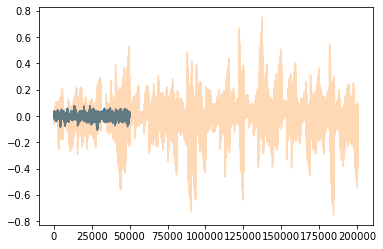

In [318]:
plt.plot(l1_list.reshape(50, -1).mean(0))

plt.plot(l2_list.reshape(50, -1).mean(0), alpha=.3)

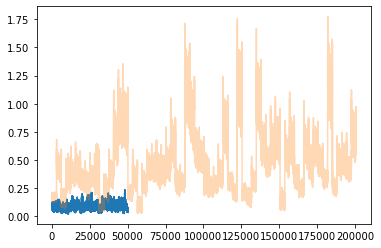

In [319]:
plt.plot(l1_list.reshape(50, -1).std(0))

plt.plot(l2_list.reshape(50, -1).std(0), alpha=.3)